In [103]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import numpy as np
import copy
from matplotlib.colors import CenteredNorm

import lenstronomy
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.param_util as param_util

from math import pi

import functorch
import matplotlib.pyplot as plt
import torch

from caustic.constants import arcsec_to_rad, rad_to_arcsec
from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.lenses import NFW, Point, SIS, SIE, MultiplaneLens
from caustic.sources import Sersic
from caustic.utils import get_meshgrid

## NFW

For some reason, lenstronomy does not appear to transform NFW parameters self-consistently...

In [170]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
import lenstronomy.Util.constants as const
from lenstronomy.Cosmo.background import Background

In [176]:
FlatLambdaCDMCosmology().rho_cr_0

127052815397.49835

In [195]:
cosmo_ls = LensCosmo(0.001, 5.0)

In [196]:
M_true = 1e13
c_true = 15.0
Rs_angle, alpha_Rs = cosmo_ls.nfw_physical2angle(M_true, c_true)

In [197]:
def nfw_angle2physical(cosmo_ls, Rs_angle, alpha_Rs):
    """
    converts the angular parameters into the physical ones for an NFW profile

    :param alpha_Rs: observed bending angle at the scale radius in units of arcsec
    :param Rs_angle: scale radius in units of arcsec
    :return: rho0 [Msun/Mpc^3], Rs [Mpc], c, r200 [Mpc], M200 [Msun]
    """
    Rs = Rs_angle * const.arcsec * cosmo_ls.dd   # good
    theta_scaled = alpha_Rs * cosmo_ls.sigma_crit * cosmo_ls.dd * const.arcsec   # ???
    rho0 = theta_scaled / (4 * Rs ** 2 * (1 + np.log(1. / 2.)))
    rho0_com = rho0 / cosmo_ls.h**2
    c = cosmo_ls.nfw_param.c_rho0(rho0_com, cosmo_ls.z_lens)
    
    r200 = c * Rs
    M200 = cosmo_ls.nfw_param.M_r200(r200 * cosmo_ls.h, cosmo_ls.z_lens) / cosmo_ls.h
    return rho0, Rs, c, r200, M200

In [198]:
rho0, Rs, c, r200, M200 = nfw_angle2physical(cosmo_ls, Rs_angle, alpha_Rs)

In [193]:
c_true, c.item()

(15.0, 17.1870003981021)

In [194]:
M_true, M200 * cosmo_ls.h

(10000000000000.0, 10177906980200.463)

## Lenstronomy crosscheck

In [3]:
device = "cpu"
cosmology = FlatLambdaCDMCosmology()
res = 0.05
nx = 200
ny = 200
thx, thy = get_meshgrid(res, nx, ny)

# Source for testing
# sersic = Sersic(use_lenstronomy_k=True)
# thx0_src = torch.tensor(0.2)
# thy0_src = torch.tensor(-0.5)
# phi_src = torch.tensor(pi / 6)
# q_src = torch.tensor(0.5)
# index_src = torch.tensor(1.5)
# th_e_src = torch.tensor(0.1)
# I_e_src = torch.tensor(100.0)

# Lens
sie = SIE()
thx0_sie = torch.tensor(0.9)
thy0_sie = torch.tensor(-0.4)
q_sie = torch.tensor(0.7)
phi_sie = torch.tensor(pi / 3)
b_sie = torch.tensor(1.4)

In [338]:
res = 0.05  # size of pixel in angular coordinates #
ra_at_xy_0, dec_at_xy_0 = (
    -5 + res / 2,
    -5 + res / 2,
)  # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = (
    np.array([[1, 0], [0, 1]]) * res
)  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {
    "nx": nx,
    "ny": ny,  # number of pixels per axis
    "ra_at_xy_0": ra_at_xy_0,  # RA at pixel (0,0)
    "dec_at_xy_0": dec_at_xy_0,  # DEC at pixel (0,0)
    "transform_pix2angle": transform_pix2angle,
}
pixel_grid = PixelGrid(**kwargs_pixel)

# kwargs_psf = {"psf_type": "NONE"}
# psf = PSF(**kwargs_psf)

In [339]:
lens_model_list = ["SIE"]
lensModel = LensModel(lens_model_list=lens_model_list)
e1, e2 = param_util.phi_q2_ellipticity(phi=phi_sie.item(), q=q_sie.item())
kwargs_lens = [
    {
        "theta_E": b_sie.item(),
        "e1": e1,
        "e2": e2,
        "center_x": thx0_sie.item(),
        "center_y": thy0_sie.item(),
    }
]

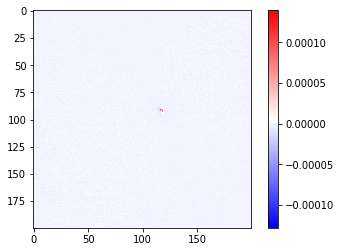

In [340]:
kappa = sie.kappa(
    thx, thy, None, None, None, thx0_sie, thy0_sie, q_sie, phi_sie, b_sie
)
kappa_ls = lensModel.kappa(
    *pixel_grid.coordinate_grid(nx, ny), kwargs_lens
)
plt.imshow((kappa_ls - kappa.numpy()), cmap="bwr")
# plt.imshow(np.log10(kappa.numpy()), cmap="bwr", vmin=-1, vmax=1.4)
plt.colorbar()

In [343]:
assert np.allclose(kappa.numpy(), kappa_ls, atol=1e-5)

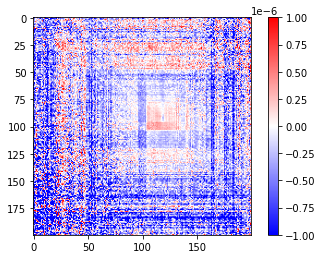

In [294]:
Psi = sie.Psi(
    thx, thy, None, None, None, thx0_sie, thy0_sie, q_sie, phi_sie, b_sie
)
Psi_ls = lensModel.potential(
    *pixel_grid.coordinate_grid(nx, ny), kwargs_lens
)
plt.imshow((Psi_ls - Psi.numpy()), vmin=-1e-6, vmax=1e-6, cmap="bwr")
# plt.imshow(Psi.numpy(), cmap="bwr")
plt.colorbar()

In [297]:
assert np.allclose(Psi.numpy(), Psi_ls)

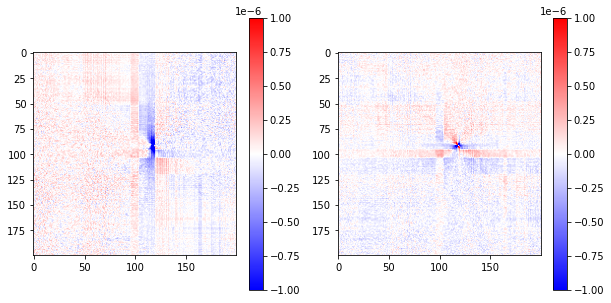

In [258]:
alpha_x, alpha_y = sie.alpha(
    thx, thy, None, None, None, thx0_sie, thy0_sie, q_sie, phi_sie, th_ein_sie
)
alpha_x_ls, alpha_y_ls = lensModel.alpha(
    *pixel_grid.coordinate_grid(nx, ny), kwargs_lens
)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow((alpha_x_ls - alpha_x.numpy()), vmin=-1e-6, vmax=1e-6, cmap="bwr")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow((alpha_y_ls - alpha_y.numpy()), vmin=-1e-6, vmax=1e-6, cmap="bwr")
plt.colorbar()

In [293]:
assert np.allclose(alpha_x.numpy(), alpha_x_ls, atol=1e-5)
assert np.allclose(alpha_y.numpy(), alpha_y_ls, atol=1e-5)

In [165]:
source_light_model_list = ["SERSIC_ELLIPSE"]
lightModel_source = LightModel(light_model_list=source_light_model_list)#, smoothing=0)

# define the parameters #
e1, e2 = param_util.phi_q2_ellipticity(phi=phi_src.item(), q=q_src.item())
kwargs_light_source = [
    {
        "amp": I_e_src.item(),
        "R_sersic": th_e_src.item(),
        "n_sersic": index_src.item(),
        "e1": e1,
        "e2": e2,
        "center_x": thx0_src.item(),
        "center_y": thy0_src.item(),
    }
]

In [166]:
brightness_caustic = sersic.brightness(
    thx, thy, thx0_src, thy0_src, q_src, phi_src, index_src, th_e_src, I_e_src
)
brightness_lenstronomy = lightModel_source.surface_brightness(
    *pixel_grid.coordinate_grid(nx, ny), kwargs_light_source
)

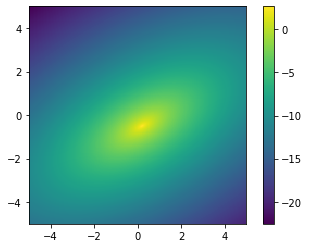

In [167]:
plt.pcolormesh(*pixel_grid.coordinate_grid(nx, ny), brightness_caustic.log10())
plt.colorbar()
plt.gca().set_aspect("equal")

/var/folders/v9/zqb5zmx5745_zvvfkmgvj3jr0000gn/T/ipykernel_4537/77912771.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(*pixel_grid.coordinate_grid(nx, ny), np.log10(brightness_lenstronomy))


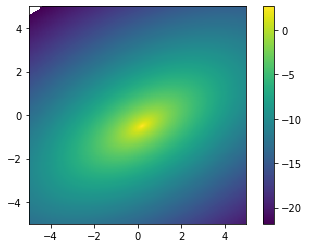

In [168]:
plt.pcolormesh(*pixel_grid.coordinate_grid(nx, ny), np.log10(brightness_lenstronomy))
plt.colorbar()
plt.gca().set_aspect("equal")

In [169]:
np.allclose(brightness_caustic, brightness_lenstronomy)

True

## $\kappa$ map

### SIE

In [32]:
from caustic.lenses import SIE
from caustic.lenses.kappa_grid import KappaGrid
from caustic.utils import get_meshgrid
import torch


device = "cpu"
# cosmology = FlatLambdaCDMCosmology()
fov = 5.0
n_pix = 32
res = fov / n_pix
thx, thy = get_meshgrid(res, n_pix, n_pix)

fov_map = 5.0
n_pix_map = 32
res_map = fov_map / n_pix_map
thx_map, thy_map = get_meshgrid(res_map, n_pix_map, n_pix_map)

# Lens
sie = SIE()
thx0_sie = torch.tensor(0.0)#12)
thy0_sie = torch.tensor(-0.0)#21)
q_sie = torch.tensor(0.4)
phi_sie = torch.tensor(pi / 3)
b_sie = torch.tensor(0.75)

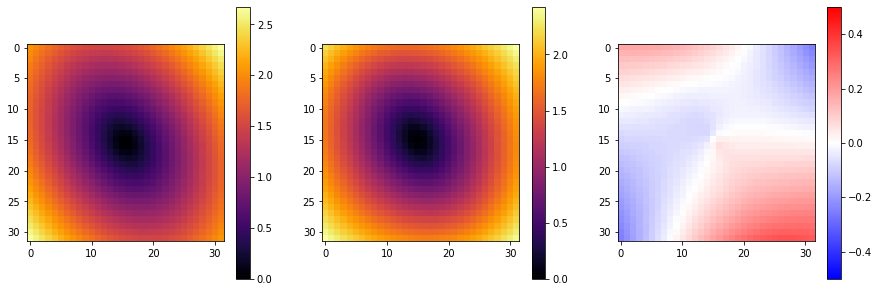

In [33]:
Psi = sie.Psi(
    thx, thy, None, None, None, thx0_sie, thy0_sie, q_sie, phi_sie, b_sie
)

kappa_lens = KappaGrid(fov_map, n_pix_map, mode="fft")
kappa_map = sie.kappa(
    thx_map, thy_map, None, None, None, thx0_sie, thy0_sie, q_sie, phi_sie, b_sie
)[None, None, :, :]
Psi_est = kappa_lens.Psi(thx, thy, None, None, None, kappa_map)
Psi_est = Psi_est.squeeze()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(Psi - Psi.min(), cmap="inferno")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(Psi_est - Psi_est.min(), cmap="inferno")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(Psi_est - Psi_est.min() - (Psi - Psi.min()), cmap="bwr", vmin=-0.5, vmax=0.5)
plt.colorbar()

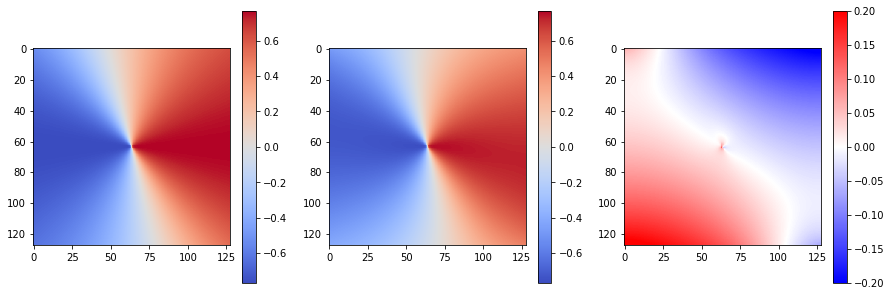

In [12]:
alpha_x, alpha_y = sie.alpha(
    thx, thy, None, None, None, thx0_sie, thy0_sie, q_sie, phi_sie, b_sie
)

kappa_lens = KappaGrid(fov_map, n_pix_map, mode="fft")
kappa_map = sie.kappa(
    thx_map, thy_map, None, None, None, thx0_sie, thy0_sie, q_sie, phi_sie, b_sie
)[None, None, :, :]
alpha_x_est, alpha_y_est = kappa_lens.alpha(thx, thy, None, None, None, kappa_map)
alpha_x_est = alpha_x_est.squeeze()
alpha_y_est = alpha_y_est.squeeze()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(alpha_x, cmap="coolwarm")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(alpha_x_est, cmap="coolwarm", vmin=alpha_x.min(), vmax=alpha_x.max())
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(alpha_x_est - alpha_x, cmap="bwr", vmin=-2e-1, vmax=2e-1)
plt.colorbar()

### Pseudo-Jaffe

In [94]:
from math import pi

import lenstronomy.Util.param_util as param_util
import numpy as np
import torch
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel

from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.lenses import PseudoJaffe
from caustic.lenses.kappa_grid import KappaGrid
from caustic.utils import get_meshgrid


device = "cpu"

In [98]:
fov = 15.0
n_pix = 2000
res = fov / n_pix
thx, thy = get_meshgrid(res, n_pix, n_pix)

lens = PseudoJaffe()
cosmology = FlatLambdaCDMCosmology()
z_l = torch.tensor(0.5)
z_s = torch.tensor(2.1)
thx0 = torch.tensor(0.0)
thy0 = torch.tensor(0.0)
r_core = torch.tensor(0.04)
r_s = torch.tensor(0.2)
kappa_0 = lens.kappa_0(z_l, z_s, cosmology, torch.tensor(1.0), r_core, r_s)

print(r_core / res, r_s / res)

Psi = lens.Psi(thx, thy, z_l, z_s, cosmology, thx0, thy0, kappa_0, r_core, r_s)
Psi -= Psi.min()

kappa_lens = KappaGrid(fov, n_pix, mode="fft")
kappa_map = lens.kappa(
    thx, thy, z_l, z_s, cosmology, thx0 + res / 2, thy0 + res / 2, kappa_0, r_core, r_s
)
kappa_map = kappa_map[None, None, :, :]
Psi_est = kappa_lens.Psi(thx, thy, None, None, None, kappa_map)
Psi_est = Psi_est.squeeze()
Psi_est -= Psi_est.min()

tensor(5.3333) tensor(26.6667)


Text(0, 0.5, 'Fraction of mass enclosed')

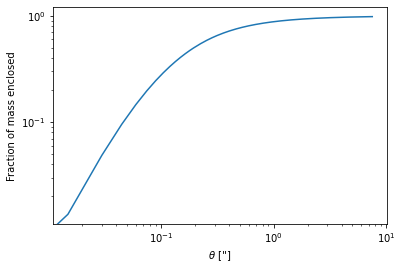

In [101]:
th_grid = torch.linspace(0, thx.max(), 500)
m_tot = lens.mass_enclosed_2d(100.0, z_l, z_s, cosmology, kappa_0, r_core, r_s)
mass_enclosed_2d = lens.mass_enclosed_2d(
    th_grid, z_l, z_s, cosmology, kappa_0, r_core, r_s
)
plt.plot(th_grid, mass_enclosed_2d / m_tot)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\theta$ ['']")
plt.ylabel("Fraction of mass enclosed")

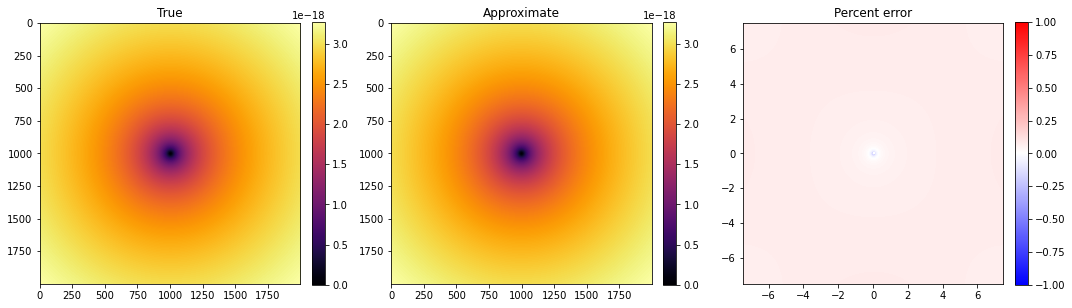

In [100]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(Psi, cmap="inferno")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("True")

plt.subplot(1, 3, 2)
plt.imshow(Psi_est, cmap="inferno")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Approximate")

plt.subplot(1, 3, 3)
plt.imshow(
    (Psi_est - Psi) / Psi * 100,
    cmap="bwr",
    norm=CenteredNorm(halfrange=1),
    extent=(-fov / 2, fov / 2, -fov / 2, fov / 2),
    origin="lower",
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Percent error")
# plt.xlim(-0.1, 0.1)
# plt.ylim(-0.1, 0.1)

plt.tight_layout()

In [24]:
alpha_x, alpha_y = lens.alpha(
    thx, thy, z_l, z_s, cosmology, thx0 + res/2, thy0 + res/2, kappa_0, r_core, r_s
)
alpha_x_est, alpha_y_est = kappa_lens.alpha(thx, thy, None, None, None, kappa_map)
alpha_x_est = alpha_x_est[0, 0]
alpha_y_est = alpha_y_est[0, 0]

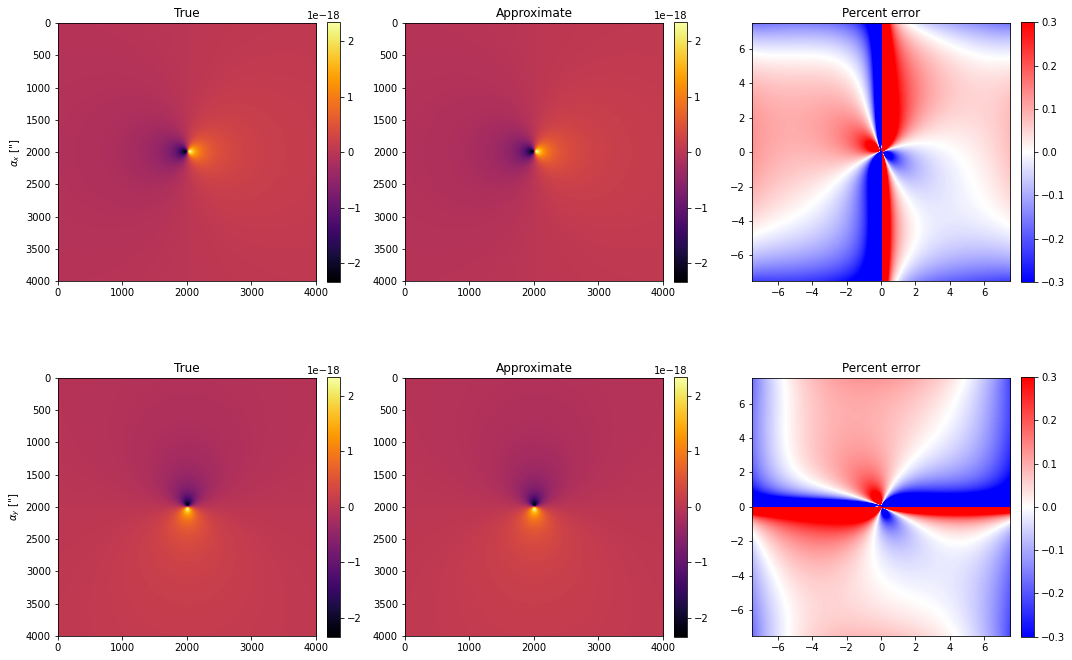

In [25]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(alpha_x, cmap="inferno")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("True")
plt.ylabel(r"$\alpha_x$ ['']")

plt.subplot(2, 3, 2)
plt.imshow(alpha_x_est, cmap="inferno")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Approximate")

plt.subplot(2, 3, 3)
plt.imshow(
    (alpha_x_est - alpha_x) / alpha_x * 100,
    cmap="bwr",
    norm=CenteredNorm(halfrange=0.3),
    extent=(-fov / 2, fov / 2, -fov / 2, fov / 2),
)
# plt.xlim(-0.1, 0.1)
# plt.ylim(-0.1, 0.1)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Percent error")

plt.subplot(2, 3, 4)
plt.imshow(alpha_y, cmap="inferno")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("True")
plt.ylabel(r"$\alpha_y$ ['']")

plt.subplot(2, 3, 5)
plt.imshow(alpha_y_est, cmap="inferno")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Approximate")

plt.subplot(2, 3, 6)
plt.imshow(
    (alpha_y_est - alpha_y) / alpha_y * 100,
    cmap="bwr",
    norm=CenteredNorm(halfrange=0.3),
    extent=(-fov / 2, fov / 2, -fov / 2, fov / 2),
)
# plt.xlim(-0.1, 0.1)
# plt.ylim(-0.1, 0.1)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Percent error")

plt.tight_layout()

## Solving the lens equation

In [ ]:
from typing import Union
from caustic.lenses.base import AbstractThinLens, AbstractThickLens


def forward_raytrace(
    thx0_src,
    thy0_src,
    lens,
    z_l,
    z_s,
    cosmology,
    *args_lens,
    **kwargs_lens,
):
    def fn(thx, thy):
        """
        Function to minimize: distance between reverse ray-traced points and source's
        position.
        """
        bx, by = lens.raytrace(thx, thy, z_l, z_s, cosmology, *args_lens, **kwargs_lens)
        return (bx - thx0_src)**2 + (by - thy0_src)**2
    
    # TODO: implement. Could get guesses for image positions and fit from there.
    raise NotImplementedError()


lens = ...
thx0_src, thy0_src = -0.1, 0.08
thxs_img, thys_img = get_image_positions(thx0_src, thy0_src, lens, z_l, z_s, cosmology, ...)

## EPL test

In [3]:
from typing import Any, Dict, List, Tuple

import numpy as np
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel

from caustic.lenses import AbstractThinLens
from caustic.utils import get_meshgrid


def setup_grids(res=0.05, n_pix=200, dtype=torch.float32):
    # Caustic setup
    thx, thy = get_meshgrid(res, n_pix, n_pix, dtype=dtype)

    # Lenstronomy setup
    ra_at_xy_0, dec_at_xy_0 = (-5 + res / 2, -5 + res / 2)
    transform_pix2angle = np.array([[1, 0], [0, 1]]) * res
    kwargs_pixel = {
        "nx": n_pix,
        "ny": n_pix,  # number of pixels per axis
        "ra_at_xy_0": ra_at_xy_0,
        "dec_at_xy_0": dec_at_xy_0,
        "transform_pix2angle": transform_pix2angle,
    }
    pixel_grid = PixelGrid(**kwargs_pixel)
    thx_ls, thy_ls = pixel_grid.coordinate_grid(n_pix, n_pix)
    return thx, thy, thx_ls, thy_ls

In [4]:
from math import pi

import lenstronomy.Util.param_util as param_util
import torch
from lenstronomy.LensModel.lens_model import LensModel

from caustic.lenses import EPL

In [25]:
# Models
lens = EPL()
lens_model_list = [
    "EPL"
]  # there's also EPL_NUMBA in lenstronomy, but shouldn't make a difference
lens_ls = LensModel(lens_model_list=lens_model_list)

# Parameters
thx0 = torch.tensor(0.912)
thy0 = torch.tensor(-0.442)
q = torch.tensor(0.7)
phi = torch.tensor(pi / 3)
b = torch.tensor(1.4)
t = torch.tensor(1.0)
s = torch.tensor(0.0)
args = (None, None, None, thx0, thy0, q, phi, b, t, s)
e1, e2 = param_util.phi_q2_ellipticity(phi=phi.item(), q=q.item())
kwargs_ls = [
    {
        "theta_E": (b / q.sqrt()).item(),
        "e1": e1,
        "e2": e2,
        "center_x": thx0.item(),
        "center_y": thy0.item(),
        "gamma": t.item() + 1.0,  # important: ADD +1
    }
]

In [26]:
thx, thy, thx_ls, thy_ls = setup_grids()

alpha_x, alpha_y = lens.alpha(thx, thy, *args)
alpha_x_ls, alpha_y_ls = lens_ls.alpha(thx_ls, thy_ls, kwargs_ls)

Psi = lens.Psi(thx, thy, *args)
Psi_ls = lens_ls.potential(thx_ls, thy_ls, kwargs_ls)

kappa = lens.kappa(thx, thy, *args)
kappa_ls = lens_ls.kappa(thx_ls, thy_ls, kwargs_ls)

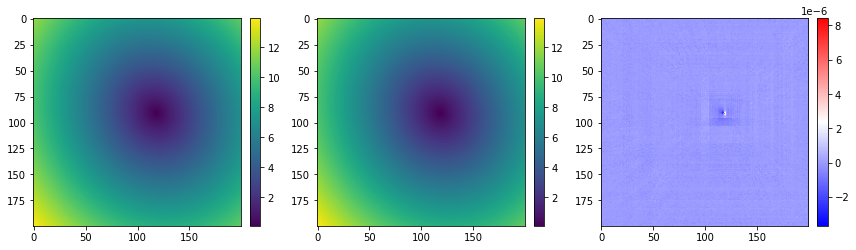

In [27]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(Psi)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 2)
plt.imshow(Psi_ls)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1, 3, 3)
plt.imshow((Psi - Psi_ls) / Psi_ls, cmap="bwr")#, vmin=-3e-5, vmax=3e-5, cmap="bwr")
# plt.imshow(Psi / Psi_ls, vmin=0.9999, vmax=1.0001)
plt.colorbar(fraction=0.046, pad=0.04)
# plt.xlim(100, 150)
# plt.ylim(125, 75)

plt.tight_layout()

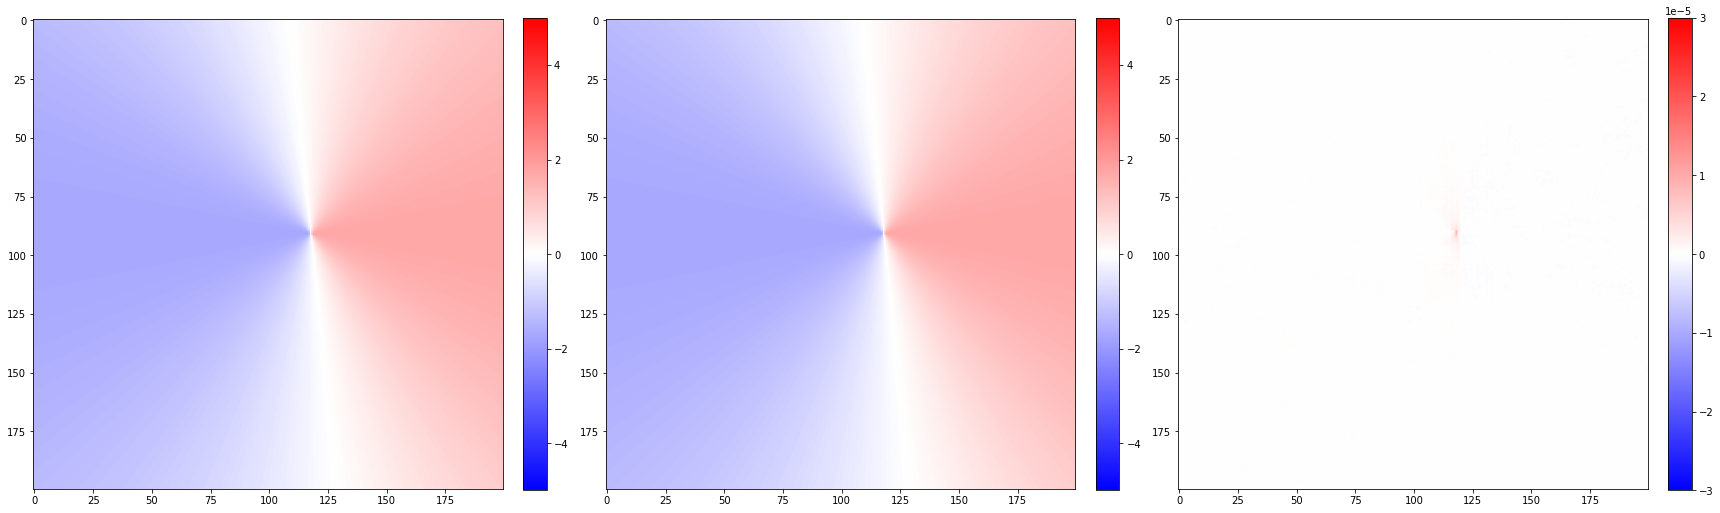

In [28]:
plt.figure(figsize=(24, 8))

plt.subplot(1, 3, 1)
plt.imshow(alpha_x, vmin=-5, vmax=5, cmap="bwr")
plt.colorbar(fraction=0.046, pad=0.04)
# plt.xlim(100, 150)
# plt.ylim(125, 75)

plt.subplot(1, 3, 2)
plt.imshow(alpha_x_ls, vmin=-5, vmax=5, cmap="bwr")
plt.colorbar(fraction=0.046, pad=0.04)
# plt.xlim(100, 150)
# plt.ylim(125, 75)

plt.subplot(1, 3, 3)
plt.imshow(alpha_x - alpha_x_ls, vmin=-3e-5, vmax=3e-5, cmap="bwr")
# plt.imshow(alpha_x / alpha_x_ls, vmin=0.9999, vmax=1.0001)
plt.colorbar(fraction=0.046, pad=0.04)
# plt.xlim(100, 150)
# plt.ylim(125, 75)

plt.tight_layout()

In [29]:
(
    np.allclose(alpha_x.numpy(), alpha_x_ls, rtol=1e-100, atol=4.5e-5),
    np.allclose(alpha_y.numpy(), alpha_y_ls, rtol=1e-100, atol=4.5e-5),
)

(True, True)

In [30]:
np.allclose(kappa.numpy(), kappa_ls, rtol=1.5e-5, atol=1e-100)

True

In [31]:
np.allclose((Psi - Psi.min()).numpy(), Psi - Psi.min(), rtol=1e-5, atol=1e-8)

True

## Data loading for simulating lenses

In [105]:
from caustic.datasets import HDF5Dataset

In [106]:
ds_src = HDF5Dataset("/Users/amcoogan/Work/Lensing/data/probes.h5", ["galaxies"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


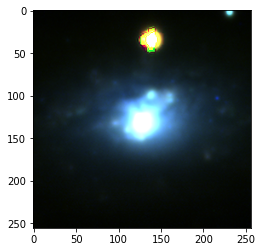

In [107]:
plt.imshow(ds_src[540]["galaxies"])

In [112]:
path_to_probes_data = "../../data/probes.h5"
ds_src = HDF5Dataset(path_to_probes_data, ["galaxies"])

In [122]:
image.shape

torch.Size([256, 256, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


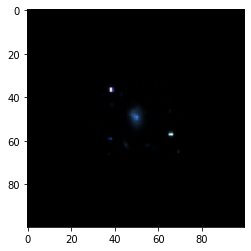

In [126]:
img_src = ImageSource("cpu")
image = torch.tensor(ds_src[0]["galaxies"]).movedim(-1, 0).unsqueeze(0)
plt.imshow(
    img_src.brightness(
        thx, thy, torch.tensor(0.0), torch.tensor(0.0), image, torch.tensor(1.0)
    )[0].movedim(0, -1)
)

In [108]:
from dataclasses import dataclass, field
import torch
from torch import Tensor
from caustic.cosmology import AbstractCosmology, FlatLambdaCDMCosmology
from caustic.lenses import KappaGrid
from caustic.sources import ImageSource
from caustic.utils import get_meshgrid

fov = 5.0
n_pix = 100
res = fov / n_pix
thx, thy = get_meshgrid(res, n_pix, n_pix)
z_l = torch.tensor(0.5)
z_s = torch.tensor(2.1)
cosmology = FlatLambdaCDMCosmology()


@dataclass
class LensingSystem:
    thx: Tensor
    thy: Tensor
    z_l: Tensor
    z_s: Tensor
    cosmology: AbstractCosmology
    lens: KappaGrid = field(init=False)
    src: ImageSource = field(init=False)

    def __post_init__(self):
        n_pix = self.thx.shape[0]
        fov = (self.thx[0, 1] - self.thx[0, 0]) * n_pix
        self.lens = KappaGrid(fov, n_pix, dtype=thx.dtype, device=thx.device)
        self.src = ImageSource(device=thx.device)

    def __call__(self, kappa_map, src_image):
        ax, ay = self.lens(
            self.thx, self.thy, self.z_l, self.z_s, self.cosmology, kappa_map
        )
        bx = self.thx - ax
        by = self.thy - ay
        return self.src(bx, by, 0.0, 0.0, src_image, self.lens.fov)


lensing_system = LensingSystem(thx, thy, z_l, z_s, cosmology)
# Set up datasets and loaders
path_to_illustris_data = "../../data/probes.h5"
ds_lens = HDF5Dataset(path_to_illustris_data, illustris_keys)
dl_lens = torch.utils.data.DataLoader(ds_lens)
ds_src = HDF5Dataset(path_to_probes_data, probes_keys)
dl_src = torch.utils.data.DataLoader(ds_src)
for kappa_map, src_image in zip(dl_lens, dl_src):
    # Generate observation
    observation = lensing_system(kappa_map, src_image)

NameError: name 'path_to_illustris_data' is not defined

In [7]:
LensingSystem(thx, thy, z_l, z_s, cosmology)

Simulator(thx=tensor([[-2.4750, -2.4250, -2.3750,  ...,  2.3750,  2.4250,  2.4750],
        [-2.4750, -2.4250, -2.3750,  ...,  2.3750,  2.4250,  2.4750],
        [-2.4750, -2.4250, -2.3750,  ...,  2.3750,  2.4250,  2.4750],
        ...,
        [-2.4750, -2.4250, -2.3750,  ...,  2.3750,  2.4250,  2.4750],
        [-2.4750, -2.4250, -2.3750,  ...,  2.3750,  2.4250,  2.4750],
        [-2.4750, -2.4250, -2.3750,  ...,  2.3750,  2.4250,  2.4750]]), thy=tensor([[-2.4750, -2.4750, -2.4750,  ..., -2.4750, -2.4750, -2.4750],
        [-2.4250, -2.4250, -2.4250,  ..., -2.4250, -2.4250, -2.4250],
        [-2.3750, -2.3750, -2.3750,  ..., -2.3750, -2.3750, -2.3750],
        ...,
        [ 2.3750,  2.3750,  2.3750,  ...,  2.3750,  2.3750,  2.3750],
        [ 2.4250,  2.4250,  2.4250,  ...,  2.4250,  2.4250,  2.4250],
        [ 2.4750,  2.4750,  2.4750,  ...,  2.4750,  2.4750,  2.4750]]), z_l=tensor(0.5000), z_s=tensor(2.1000), cosmology=<caustic.cosmology.FlatLambdaCDMCosmology object at 0x17b4678b

In [ ]:
dl_src = ...
dl_lens = ...